### Loan Prediction Preprocessing and Training Data Development

In this notebook, I am trying to create a cleaned development dataset for which I can complete the modeling step of the project (next!).

I identified categorical variables and converted them to dummy variables using pd.get_dummies(). 

As discovered in the previous notebook, the target variable ('Default') suffers from severe class imbalance. Keeping the data as-is, is inappropriate for machine learning models. Therefore, I will need to rebalance the classes.

In [62]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [63]:
#load the dataset
data = pd.read_csv('transformed_data.csv')

I know my data is clean from my previous notebooks.  I will next use sklearn's train_test_split on my dataset.  This way when I preprocess my data, I can preprocess my training and testing sets separately to avoid any data leakage (information from the test set unintentionally influences the training process). 

In [64]:
X = data.drop(['Default'], axis = 1)
y = data['Default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =42)

Since my features are a combination of numerical and categorical features, I will need to transform them separately. To do this I will use the ColumnTransformer from sklearn.  I will need group the numerical columns and categorical columns together, respectively.

In [65]:
print(data.columns)

Index(['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed',
       'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio', 'Default',
       'HasCoSigner_Yes', 'Education_High School', 'Education_Master's',
       'Education_PhD', 'EmploymentType_Part-time',
       'EmploymentType_Self-employed', 'EmploymentType_Unemployed',
       'MaritalStatus_Married', 'MaritalStatus_Single', 'HasMortgage_Yes',
       'HasDependents_Yes', 'LoanPurpose_Business', 'LoanPurpose_Education',
       'LoanPurpose_Home', 'LoanPurpose_Other'],
      dtype='object')


In [66]:
numerical_cols = ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio']
categorical_cols = ['Default', 'HasCoSigner_Yes', 'Education_High School', "Education_Master's", 
                    'Education_PhD', 'EmploymentType_Part-time', 'EmploymentType_Self-employed', 
                    'EmploymentType_Unemployed', 'MaritalStatus_Married', 'MaritalStatus_Single', 
                    'HasMortgage_Yes', 'HasDependents_Yes', 'LoanPurpose_Business', 
                    'LoanPurpose_Education', 'LoanPurpose_Home', 'LoanPurpose_Other']

In [67]:
preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), numerical_cols)], remainder='passthrough')

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

Since my categorical variables were already encoded in previous steps (data wrangling), this ColumnTransformer will transform and scale the numerical columns while keeping the already encoded categorical variables untouched.

In [68]:
#check transformations

X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=X.columns)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=X.columns)


original_stats = X.describe()
scaled_train_stats = X_train_transformed_df.describe()
scaled_test_stats = X_test_transformed_df.describe()

# Print the summary statistics
print("Original Data:")
print(original_stats)

print("\nScaled Training Data:")
print(scaled_train_stats)

print("\nScaled Testing Data:")
print(scaled_test_stats)

Original Data:
                 Age         Income     LoanAmount    CreditScore  \
count  255347.000000  255347.000000  255347.000000  255347.000000   
mean       43.498306   82499.304597  127578.865512     574.264346   
std        14.990258   38963.013729   70840.706142     158.903867   
min        18.000000   15000.000000    5000.000000     300.000000   
25%        31.000000   48825.500000   66156.000000     437.000000   
50%        43.000000   82466.000000  127556.000000     574.000000   
75%        56.000000  116219.000000  188985.000000     712.000000   
max        69.000000  149999.000000  249999.000000     849.000000   

       MonthsEmployed  NumCreditLines   InterestRate       LoanTerm  \
count   255347.000000   255347.000000  255347.000000  255347.000000   
mean        59.541976        2.501036      13.492773      36.025894   
std         34.643376        1.117018       6.636443      16.969330   
min          0.000000        1.000000       2.000000      12.000000   
25%     

Since test_train_split produced np arrays, I needed to convert them back to a dataframe to use the 'describe' method to look at the summary statistics.

Looking at the summary statistics of the train and test data, the mean and std for the numerical variables are approximately 0 and 1, respectively.  This is the output we were looking for to confirm the numerical data was properly scaled. As for categorical variables, it's vital to ensure they are appropriately encoded which was done previously.

Now that I feel confident about my training and testing data, I need to work on the class imbalance problem. To handle this, I intend to use the SMOTE technique which is designed to address the issue of class imbalance by generating synthetic examples of the minority class.

In [69]:
smote = SMOTE(random_state= 42)
X_train_res, y_train_res = smote.fit_resample(X_train_transformed, y_train)

I applied SMOTE only to the training data to avoid any data leakage. Next, I want to verify that the class is rebalanced.

Original Class Distribution:
Default
0    180524
1     23753
Name: count, dtype: int64

Resampled Class Distribution:
Default
0    180524
1    180524
Name: count, dtype: int64


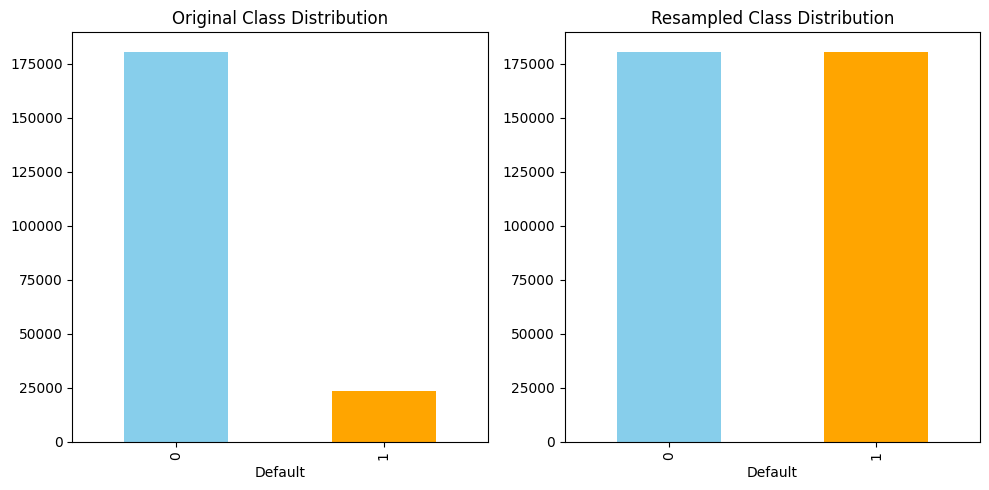

In [70]:
original_class_dist = pd.Series(y_train).value_counts()
res_class_dist = pd.Series(y_train_res).value_counts()

print("Original Class Distribution:")
print(original_class_dist)

print("\nResampled Class Distribution:")
print(res_class_dist)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
original_class_dist.plot(kind='bar', color=['skyblue', 'orange'])
plt.title("Original Class Distribution")

plt.subplot(1, 2, 2)
res_class_dist.plot(kind='bar', color=['skyblue', 'orange'])
plt.title("Resampled Class Distribution")

plt.tight_layout()
plt.show()

It's clear that the data was resampled as seen above. The original class distribution showed a clear imbalance, meanwhile, the resampled distribution shows an even balance among classes (not default: 0, default: 1). 

A problem with this resampling is the number of samples in the original minority class (default: 1). In the resampled distribution, the default: 1 class went from about 25000 samples to over 180000. This may lead to oversampling so I will need to reduce the samples.

In [71]:
class_counts = np.bincount(y_train)
min_class_count = class_counts[1]
maj_class_count = class_counts[0]
imbalance_ratio = maj_class_count / min_class_count

desired_ratio = 0.3

sampling_strategy = {0: maj_class_count, 1: int(maj_class_count * desired_ratio)}

smote = SMOTE(sampling_strategy = sampling_strategy, random_state= 42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)

Original Class Distribution:
Default
0    180524
1     23753
Name: count, dtype: int64

Resampled Class Distribution (Oversample):
Default
0    180524
1    180524
Name: count, dtype: int64

Resampled Class Distribution (Controlled):
Default
0    180524
1     54157
Name: count, dtype: int64


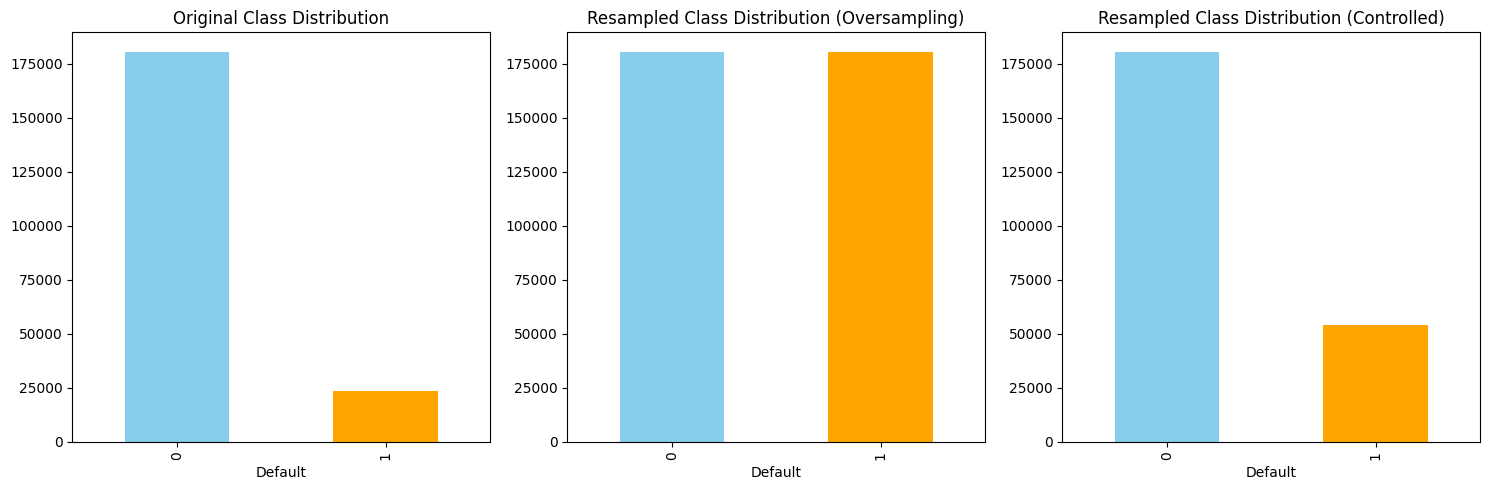

In [72]:
resampled_class_dist = pd.Series(y_train_resampled).value_counts()

plt.figure(figsize=(15, 5))

print("Original Class Distribution:")
print(original_class_dist)

print("\nResampled Class Distribution (Oversample):")
print(res_class_dist)

print("\nResampled Class Distribution (Controlled):")
print(resampled_class_dist)

plt.subplot(1, 3, 1)
original_class_dist.plot(kind='bar', color=['skyblue', 'orange'])
plt.title("Original Class Distribution")

plt.subplot(1, 3, 2)
res_class_dist.plot(kind='bar', color=['skyblue', 'orange'])
plt.title("Resampled Class Distribution (Oversampling)")

plt.subplot(1, 3, 3)
resampled_class_dist.plot(kind='bar', color=['skyblue', 'orange'])
plt.title("Resampled Class Distribution (Controlled)")

plt.tight_layout()
plt.show()

The majority class still dominated the minority class even though there are roughly twice as many minority class samples. I need to undersample the majority class to make the distribution more even.

Original Class Distribution:
Default
0    180524
1     23753
Name: count, dtype: int64

Resampled Class Distribution (Oversample):
Default
0    180524
1    180524
Name: count, dtype: int64

Resampled Class Distribution (Controlled):
Default
0    54157
1    54157
Name: count, dtype: int64


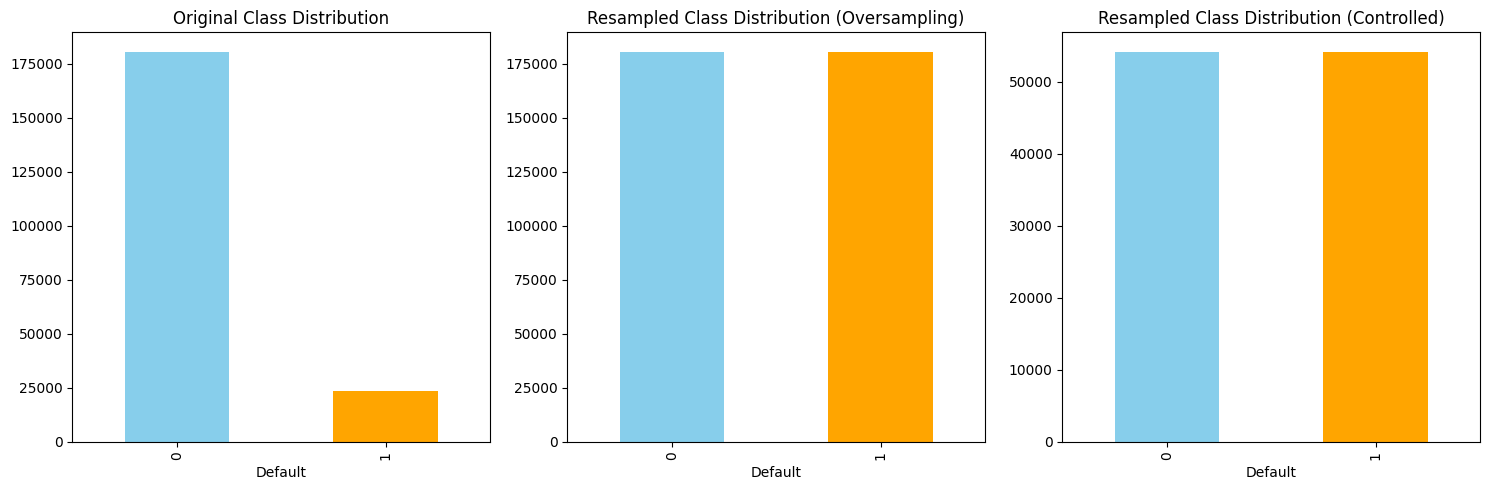

In [73]:
min_class_count_after_oversamp = int(maj_class_count * desired_ratio)

pipeline = Pipeline([
    ('resample', SMOTE(sampling_strategy={1: int(min_class_count_after_oversamp)}, random_state=42)),
    ('undersample', RandomUnderSampler(sampling_strategy={0: min_class_count_after_oversamp}, random_state=42))
])

X_train_resampled_controlled, y_train_resampled_controlled = pipeline.fit_resample(X_train_transformed, y_train)

resampled_class_dist = pd.Series(y_train_resampled_controlled).value_counts()
print("Original Class Distribution:")
print(original_class_dist)

print("\nResampled Class Distribution (Oversample):")
print(res_class_dist)

print("\nResampled Class Distribution (Controlled):")
print(resampled_class_dist)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
original_class_dist.plot(kind='bar', color=['skyblue', 'orange'])
plt.title("Original Class Distribution")

plt.subplot(1, 3, 2)
res_class_dist.plot(kind='bar', color=['skyblue', 'orange'])
plt.title("Resampled Class Distribution (Oversampling)")

plt.subplot(1, 3, 3)
resampled_class_dist.plot(kind='bar', color=['skyblue', 'orange'])
plt.title("Resampled Class Distribution (Controlled)")

plt.tight_layout()
plt.show()

Now the class distribution is even.

In this notebook, I split my data into training sets and testing sets. Additionally, the training sets were resampled to help alleviate the class imbalance dilemma associated with the data.  My next step will be model development and implementation.

In [74]:
X_train_resampled_controlled_df = pd.DataFrame(X_train_resampled_controlled, columns=X_train.columns)
y_train_resampled_controlled_df = pd.DataFrame(y_train_resampled_controlled, columns=['Default'])
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=X_test.columns)
y_test_df = pd.DataFrame(y_test, columns=['Default'])

X_train_resampled_controlled_df.to_csv('X_train_preprocessed.csv', index=False)
y_train_resampled_controlled_df.to_csv('y_train_preprocessed.csv', index=False)
X_test_transformed_df.to_csv('X_test_transformed.csv', index=False)
y_test_df.to_csv('y_test.csv', index=False)


Resampled Class Distribution (Desired Ratio: 0.6):
Default
0    35629
1    23753
Name: count, dtype: int64

Resampled Class Distribution (Desired Ratio: 0.65):
Default
0    44112
1    23753
Name: count, dtype: int64


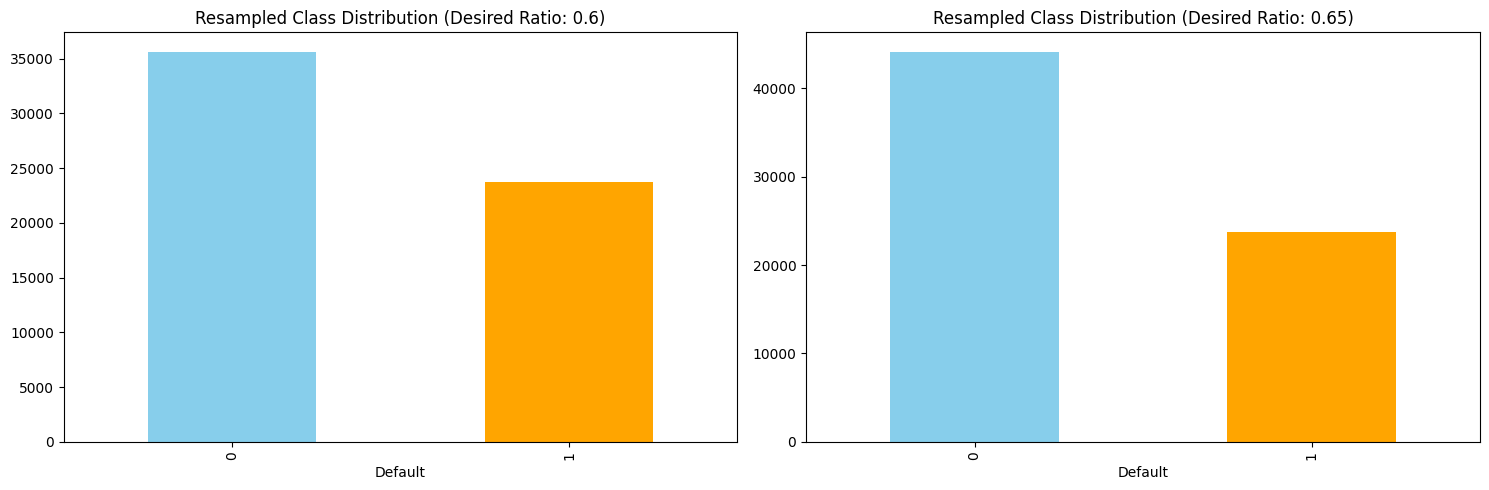

In [75]:
class_counts = np.bincount(y_train)
min_class_count = class_counts[1]
maj_class_count = class_counts[0]

desired_ratios = [0.6, 0.65]

plt.figure(figsize=(15, 5))

for i, desired_ratio in enumerate(desired_ratios, 1):
    maj_class_count_after_undersamp = int(min_class_count / (1 - desired_ratio) * desired_ratio)

    rus = RandomUnderSampler(sampling_strategy={0: maj_class_count_after_undersamp}, random_state=42)
    X_train_resampled, y_train_resampled = rus.fit_resample(X_train_transformed, y_train)

    resampled_class_dist = pd.Series(y_train_resampled).value_counts()

    print(f"\nResampled Class Distribution (Desired Ratio: {desired_ratio}):")
    print(resampled_class_dist)

    plt.subplot(1, len(desired_ratios), i)
    resampled_class_dist.plot(kind='bar', color=['skyblue', 'orange'])
    plt.title(f"Resampled Class Distribution (Desired Ratio: {desired_ratio})")

plt.tight_layout()
plt.show()

for desired_ratio in desired_ratios:
    maj_class_count_after_undersamp = int(min_class_count / (1 - desired_ratio) * desired_ratio)

    rus = RandomUnderSampler(sampling_strategy={0: maj_class_count_after_undersamp}, random_state=42)
    X_train_resampled, y_train_resampled = rus.fit_resample(X_train_transformed, y_train)

    X_train_resampled_df = pd.DataFrame(X_train_resampled, columns=X_train.columns)
    y_train_resampled_df = pd.DataFrame(y_train_resampled, columns=['Default'])

    file_prefix = f"ratio_{str(int(desired_ratio * 100)).zfill(2)}_"
    X_train_resampled_df.to_csv(f'X_train_preprocessed_{file_prefix}.csv', index=False)
    y_train_resampled_df.to_csv(f'y_train_preprocessed_{file_prefix}.csv', index=False)